# Analyse de l'incidence de la varicelle

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

# set diagram sizes
# print(plt.rcParams['figure.dpi'])  # default = 72
# print(plt.rcParams['figure.figsize'])  # default = 6.0, 4.0
# plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [12.0, 4.0]

Les données de l'incidence du syndrome grippal sont disponibles du site Web du Réseau Sentinelles. Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet.

In [1]:
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

Voici l'explication des colonnes données sur le [site d'origine](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):

| Nom de colonne | Libellé de colonne                                                                                                                   |
|----------------|-------------------------------------------------------------------------------------------------------------------------------------|
| week           | Semaine calendaire (ISO 8601)                                                                                                       |
| geo_insee      | Code de la zone géographique concernée (Code INSEE) http://www.insee.fr/fr/methodes/nomenclatures/cog/                               |
| geo_name       | Libellé de la zone géographique (ce libellé peut être modifié sans préavis)                                                         |
| inc            | Estimation de l'incidence de consultations en nombre de cas                                                                         |
| inc_low        | Estimation de la borne inférieure de l'IC95% du nombre de cas de consultation                                                       |
| inc_up         | Estimation de la borne supérieure de l'IC95% du nombre de cas de consultation                                                       |
| inc100         | Estimation du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants)                                     |
| inc100_low     | Estimation de la borne inférieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| inc100_up      | Estimation de la borne supérieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |

In [12]:
data = pd.read_csv(data_url, encoding = 'iso-8859-1', skiprows=1)
data.head(10)

week  indicator   inc  inc_low  inc_up  inc100  inc100_low  inc100_up  \
0  202305          7  6439     3806    9072      10           6         14   
1  202304          7  6300     3947    8653       9           5         13   
2  202303          7  6063     3798    8328       9           6         12   
3  202302          7  6576     3060   10092      10           5         15   
4  202301          7  8153     5470   10836      12           8         16   
5  202252          7  5171     2717    7625       8           4         12   
6  202251          7  6226     3822    8630       9           5         13   
7  202250          7  6590     3100   10080      10           5         15   
8  202249          7  5095     3212    6978       8           5         11   
9  202248          7  4985     3043    6927       8           5         11   

  geo_insee geo_name  
0        FR   France  
1        FR   France  
2        FR   France  
3        FR   France  
4        FR   France  
5        FR   France  
6        FR   France  
7        FR   France  
8        FR   France  
9        FR   France

## Contrôle Qualité
### Recherche des lignes sans donnée

In [13]:
# recherche des lignes sans données
data[data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Aucune donnée ne manque.

### Format des dates
Nos données utilisent une convention inhabituelle: le numéro de semaine est collé à l'année, donnant l'impression qu'il s'agit de nombre entier. C'est comme ça que Pandas les interprète.  
Un deuxième problème est que Pandas ne comprend pas les numéros de semaine.  Il faut lui fournir les dates de début et de fin de semaine. Nous utilisons pour cela la bibliothèque isoweek.

Comme la conversion des semaines est devenu assez complexe, nous écrivons une petite fonction Python pour cela. Ensuite, nous l'appliquons à tous les points de nos donnés.  
Les résultats vont dans une nouvelle colonne 'period'.

In [15]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]
data.head(5)

week  indicator   inc  inc_low  inc_up  inc100  inc100_low  inc100_up  \
0  202305          7  6439     3806    9072      10           6         14   
1  202304          7  6300     3947    8653       9           5         13   
2  202303          7  6063     3798    8328       9           6         12   
3  202302          7  6576     3060   10092      10           5         15   
4  202301          7  8153     5470   10836      12           8         16   

  geo_insee geo_name                period  
0        FR   France 2023-01-30/2023-02-05  
1        FR   France 2023-01-23/2023-01-29  
2        FR   France 2023-01-16/2023-01-22  
3        FR   France 2023-01-09/2023-01-15  
4        FR   France 2023-01-02/2023-01-08

Il restent deux petites modifications à faire.  
 - Premièrement, nous définissons les périodes d'observation comme nouvel index de notre jeux de données. Ceci en fait
une suite chronologique, ce qui sera pratique par la suite.  
 - Deuxièmement, nous trions les points par période, dans
le sens chronologique.

In [17]:
sorted_data = data.set_index('period').sort_index()
sorted_data.head(5)

week  indicator    inc  inc_low  inc_up  inc100  \
period                                                                     
1990-12-03/1990-12-09  199049          7   1143        0    2610       2   
1990-12-10/1990-12-16  199050          7  11079     6660   15498      20   
1990-12-17/1990-12-23  199051          7  19080    13807   24353      34   
1990-12-24/1990-12-30  199052          7  19375    13295   25455      34   
1990-12-31/1991-01-06  199101          7  15565    10271   20859      27   

                       inc100_low  inc100_up geo_insee geo_name  
period                                                           
1990-12-03/1990-12-09           0          5        FR   France  
1990-12-10/1990-12-16          12         28        FR   France  
1990-12-17/1990-12-23          25         43        FR   France  
1990-12-24/1990-12-30          23         45        FR   France  
1990-12-31/1991-01-06          18         36        FR   France

### Continuité des données
Entre la fin d'une période et le début de la période qui suit, la différence temporelle doit être zéro, ou au moins très faible. Nous laissons une "marge d'erreur" d'une seconde.

In [18]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Il n'y a pas de correction à apporter.

## Inspection visuelle

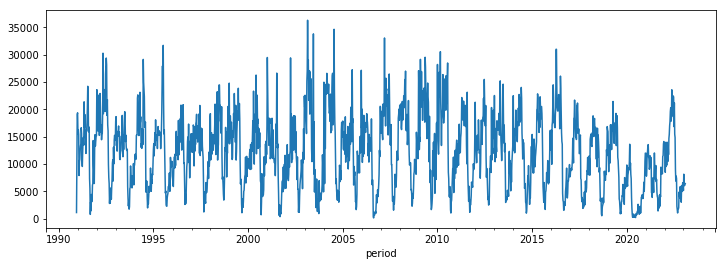

In [33]:
sorted_data['inc'].plot()

Un zoom sur les dernières années montre mieux la situation des pics en hiver.

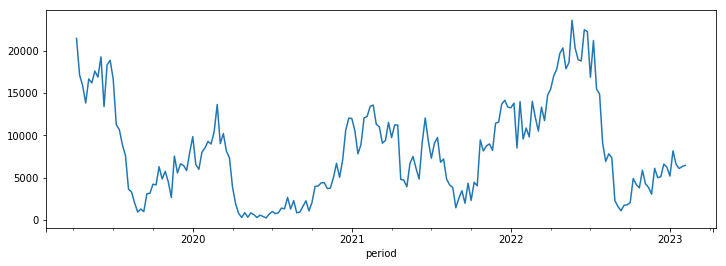

In [37]:
sorted_data['inc'][-200:].plot()

## Étude de l'incidence annuelle
### reformattage des données
Les pics d'incidence commence avec l'hiver et peuvent durer jusqu'à la fin de l'été, à cheval entre deux années civiles, nous définissons la période de référence entre deux minima de l'incidence, du 1er septembre de l'année N au 1er septembre de l'année N+1.

Notre tâche est un peu compliquée par le fait que l'année ne comporte pas un nombre entier de semaines. Nous modifions donc un peu nos périodes de référence: à la place du 1er septembre de chaque année, nous utilisons le premier jour de la semaine qui contient le 1er septembre.

Cette modification ne risque pas de fausser nos conclusions car la date a été choisie lors du minimum d'incidence.

Encore un petit détail: les données commencent en décembre 1990, ce qui rend la première année incomplète. Nous commençons donc l'analyse en 1991.

In [41]:
first_september_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991, sorted_data.index[-1].year)]

En partant de cette liste des semaines qui contiennent un 1er septembre, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste.

Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.  
Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [42]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_september_week[:-1],
                        first_september_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

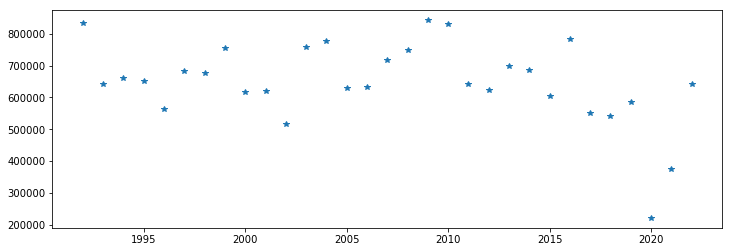

In [44]:
yearly_incidence.plot(style='*')

In [45]:
yearly_incidence[2020]

221186

Une liste triée permet de plus facilement répérer les valeurs les plus élevées (à la fin).

In [48]:
yearly_incidence.sort_values().tail(5)

2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64

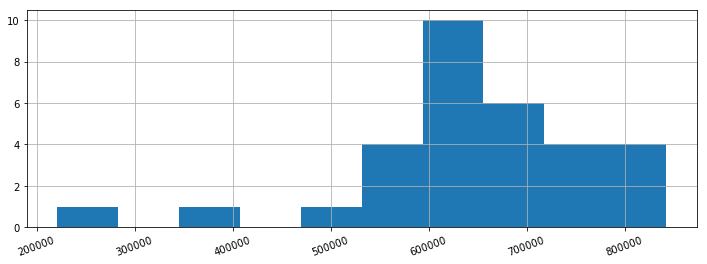

In [49]:
yearly_incidence.hist(xrot=20)